# Importing the Libraries & Loading data

In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.pipeline import Pipeline

from time import time
import os
import joblib

#  Import dataset

In [2]:
train_df = pd.read_csv("train_split.csv")
test_df = pd.read_csv("test_split.csv")
dev_df = pd.read_csv("val_split.csv")
train_df

,text,label
0,new trousers corduroy sweatshirts jackets just...,1
1,url url date 1635465 1635465 1635465t1635465 1...,0
2,we deliver medication worldwide cialis helps t...,1
3,bei enron gordian kemen on 03 15 2000 09 13 47...,0
4,isme hai na music bot,0
...,...,...
14238,north atlantic forecasts update for fyi also h...,0
14239,inn share shareinnn yahoo com writes hi all do...,0
14240,made other than that i bet you could do non ro...,0
14241,you have won as a valued vodafone customer our...,1


In [3]:
dev_df

,text,label
0,hai priya are you right what doctor said pa wh...,0
1,own your 300sq mt above authority industrialla...,1
2,𝑰 𝒘𝒂𝒔 𝒔𝒐 𝒆𝒙𝒄𝒊𝒕𝒆𝒅 𝒘𝒉𝒆𝒏 𝑰 𝒐𝒑𝒆𝒏𝒆𝒅 𝒎𝒚 𝒘𝒂𝒍𝒍𝒆𝒕 𝒂𝒏𝒅 𝒔...,1
3,password login kkindal password marketcredit,0
4,largest collection of dowlnoadable porn d d mo...,1
...,...,...
2030,ho ho big belly laugh see ya tomo,0
2031,the next newsletter dear vince thank you i fee...,0
2032,i wrote the bytecode interpreter may improve n...,0
2033,u can call me now,0


# Tiền xử lý dữ liệu & EDA

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14243 entries, 0 to 14242
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14243 non-null  object
 1   label   14243 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 222.7+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4070 non-null   object
 1   label   4070 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.7+ KB


In [6]:
# Count duplicated rows
train_df[train_df['text'].duplicated() == True].count()

text     13
label    13
dtype: int64

In [7]:
# Count duplicated rows
dev_df[dev_df['text'].duplicated() == True].count()

text     0
label    0
dtype: int64

In [8]:
# Count duplicated rows
test_df[test_df['text'].duplicated() == True].count()

text     0
label    0
dtype: int64

In [9]:
train_df = train_df.drop_duplicates(keep='first')

train_df

,text,label
0,new trousers corduroy sweatshirts jackets just...,1
1,url url date 1635465 1635465 1635465t1635465 1...,0
2,we deliver medication worldwide cialis helps t...,1
3,bei enron gordian kemen on 03 15 2000 09 13 47...,0
4,isme hai na music bot,0
...,...,...
14238,north atlantic forecasts update for fyi also h...,0
14239,inn share shareinnn yahoo com writes hi all do...,0
14240,made other than that i bet you could do non ro...,0
14241,you have won as a valued vodafone customer our...,1


In [10]:
test_df = test_df.drop_duplicates(keep='first')

test_df[test_df['label']==1]['text'][4067]

'hi ive been using coinbase which makes it really easy and safe to buy sell and store digital currency like bitcoin sign up now and get $10 of free bitcoin when you buy or sell at least $100 of digital currency claim your invite now let me know if you need help ashamoni ashamoni'

In [11]:

test_df[test_df['label']==0]['text'][4069]

'but i wont blame him either who knows if hes a newbie people that tell it to newbies are cruel'

In [12]:
train_df['label'].value_counts()/ (len(train_df))

label
0    0.700281
1    0.299719
Name: count, dtype: float64

In [13]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming or lemmatization (optional)
    # Stemming using PorterStemmer
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Return the preprocessed text
    return ' '.join(tokens)

In [14]:
# Apply preprocessing to both training and testing data
train_df['text_preprocessed'] = train_df['text'].apply(preprocess_text)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26676\1669506774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text_preprocessed'] = train_df['text'].apply(preprocess_text)


In [15]:
# Apply preprocessing to both training and testing data
dev_df['text_preprocessed'] = dev_df['text'].apply(preprocess_text)

In [16]:
test_df['text_preprocessed'] = test_df['text'].apply(preprocess_text)

In [17]:
train_df

,text,label,text_preprocessed
0,new trousers corduroy sweatshirts jackets just...,1,new trouser corduroy sweatshirt jacket arriv b...
1,url url date 1635465 1635465 1635465t1635465 1...,0,url url date 1635465 1635465 1635465t1635465 1...
2,we deliver medication worldwide cialis helps t...,1,deliv medic worldwid ciali help erect need pea...
3,bei enron gordian kemen on 03 15 2000 09 13 47...,0,bei enron gordian kemen 03 15 2000 09 13 47 je...
4,isme hai na music bot,0,ism hai na music bot
...,...,...,...
14238,north atlantic forecasts update for fyi also h...,0,north atlant forecast updat fyi also highli re...
14239,inn share shareinnn yahoo com writes hi all do...,0,inn share shareinnn yahoo com write hi anyon k...
14240,made other than that i bet you could do non ro...,0,made bet could non root follow script easili 1...
14241,you have won as a valued vodafone customer our...,1,valu vodafon custom comput pick win 150 prize ...


In [18]:
test_df

,text,label,text_preprocessed
0,whats that coming over the hill is it a monste...,0,what come hill monster hope great day thing r ...
1,i ve also just tried doing rpm rebuilddb no ch...,0,also tri rpm rebuilddb chang question file loo...
2,friday brown bag on derivative pricing hello a...,0,friday brown bag deriv price hello think peopl...
3,pdo index updateforwarded by mike a roberts ho...,0,pdo index updateforward mike robert hou ect 08...
4,▫️add member dear aftab ashiq आपको अपने 5 cont...,1,add member dear aftab ashiq आपक अपन 5 contact ...
...,...,...,...
4065,energy futures contracts project please respon...,0,energi futur contract project pleas respond hi...
4066,off work all i will be taking the following da...,0,work take follow day work thursday 9 th march ...
4067,hi ive been using coinbase which makes it real...,1,hi ive use coinbas make realli easi safe buy s...
4068,should i be stalking u,0,stalk u


In [19]:
test_df['label'].value_counts()/ (len(test_df))

label
0    0.715725
1    0.284275
Name: count, dtype: float64

## Data Visualization

In [98]:
from collections import Counter
class DataVisualizer:
    def __init__(self, df):
        self.df = df

    def generate_wordcloud(self, text, title, ax):
        wordcloud = WordCloud(stopwords=set(ENGLISH_STOP_WORDS),
                              background_color='white',
                              width=400,
                              height=400,
                              max_words=150,
                              random_state=42).generate(text)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(title)
        ax.axis('off')

    def visualize_wordclouds(self, title):
        spam_text = ' '.join(self.df[self.df['label'] == 1]['text_preprocessed'])
        ham_text = ' '.join(self.df[self.df['label'] == 0]['text_preprocessed'])

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        plt.suptitle(title, fontsize=16)
        self.generate_wordcloud(spam_text, 'Spam Word Cloud', axes[0])
        self.generate_wordcloud(ham_text, 'Ham Word Cloud', axes[1])

        plt.show()

    def visualize_label_distribution(self):
        plt.figure(figsize=(8, 6))
        ax = sns.countplot(x='label', data=self.df)
        for container in ax.containers:
            ax.bar_label(container)
        plt.title('Phân bố nhãn ')
        plt.xlabel('Nhãn')
        plt.ylabel('Số lượng')
        plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
        plt.tight_layout()
        plt.show()
    def visualize_top_spam_words(self, title, top_n=10):
        spam_text = ' '.join(self.df[self.df['label'] == 0]['text_preprocessed'])
        spam_words = [word for word in spam_text.split() if word not in ENGLISH_STOP_WORDS]

        word_counts = Counter(spam_words)
        top_words = dict(word_counts.most_common(top_n))

        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette='viridis')
        plt.title(title)
        plt.xlabel('Số lần xuất hiện')
        plt.ylabel('Từ')
        plt.show()

In [21]:
vis_train = DataVisualizer(train_df)

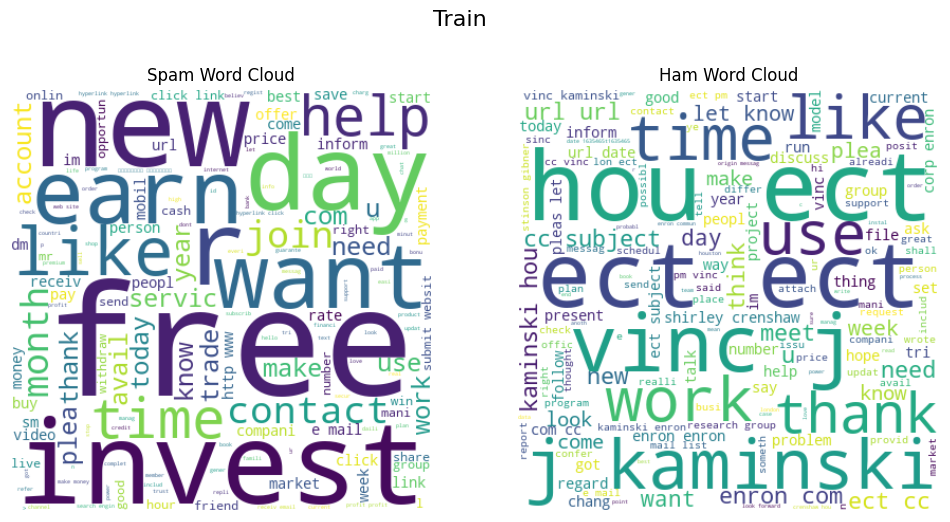

In [22]:
vis_train.visualize_wordclouds("Train")

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


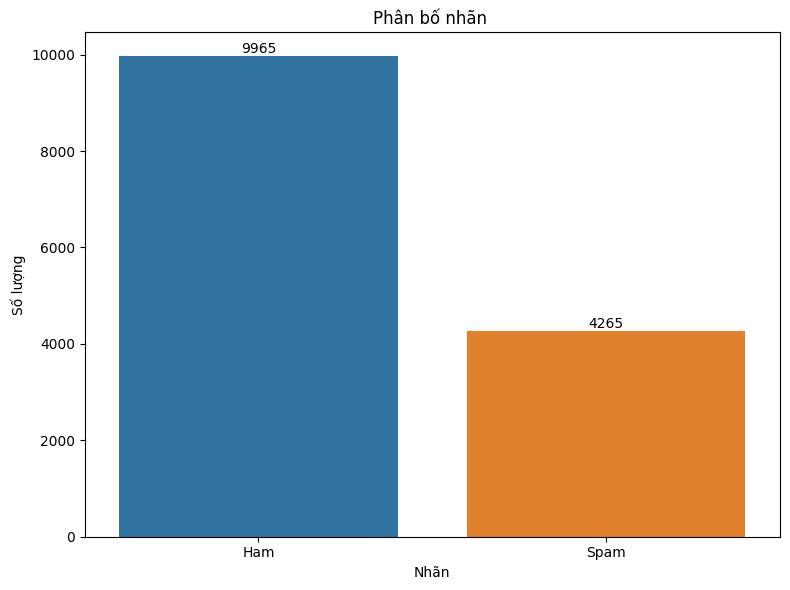

In [23]:
vis_train.visualize_label_distribution()

In [24]:
vis_dev = DataVisualizer(dev_df)

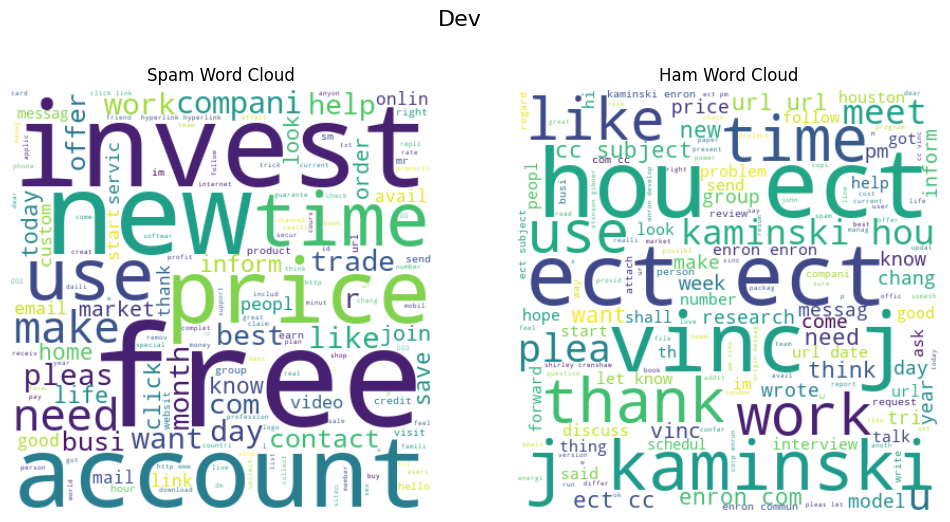

In [25]:
vis_dev.visualize_wordclouds("Dev")

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


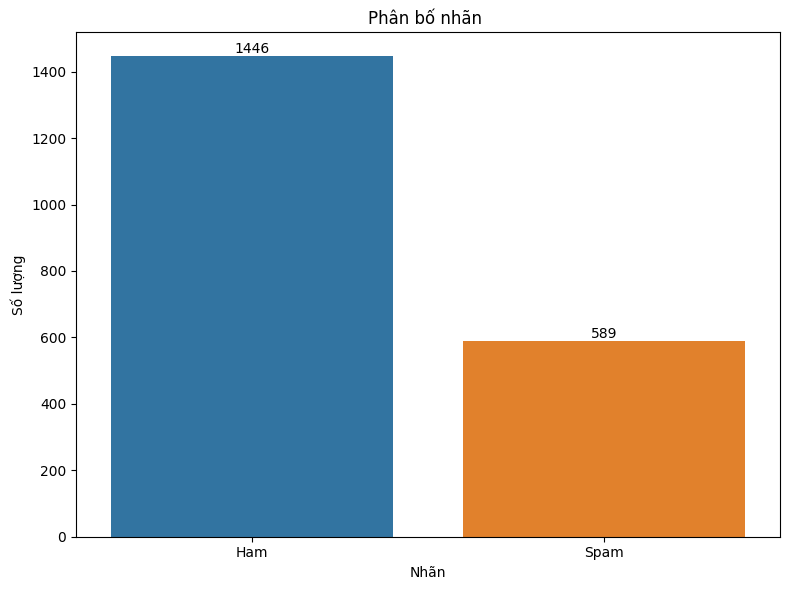

In [26]:
vis_dev.visualize_label_distribution()

In [27]:
vis_test = DataVisualizer(test_df)

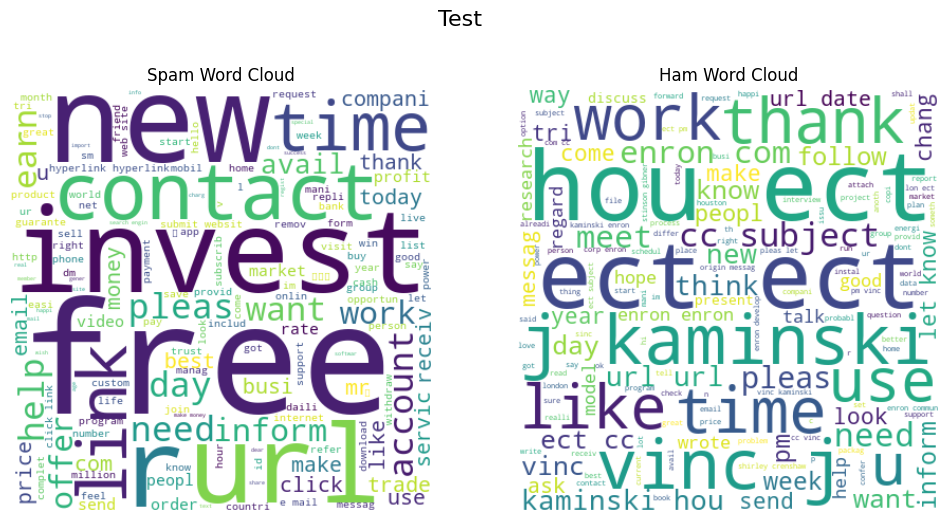

In [28]:
vis_test.visualize_wordclouds("Test")

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


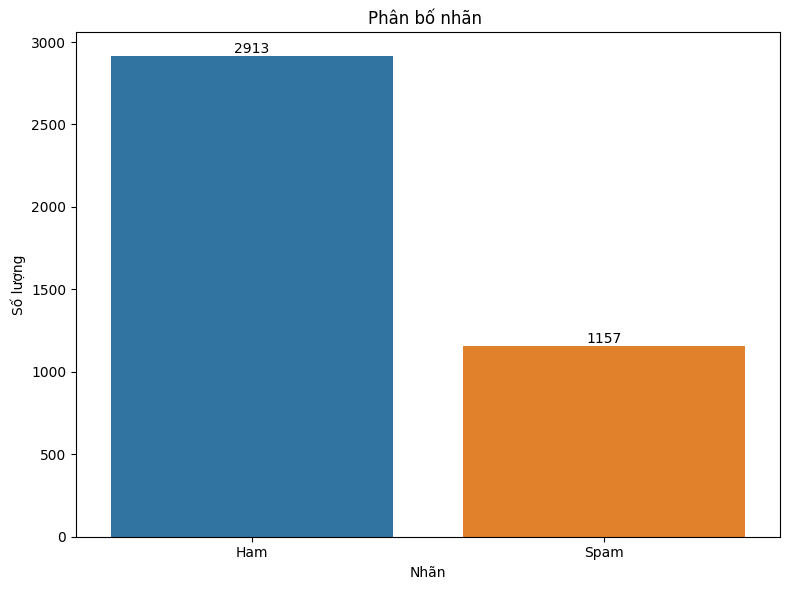

In [29]:
vis_test.visualize_label_distribution()

## Chia dữ liệu

In [30]:
X_train, y_train =  train_df['text_preprocessed'], train_df['label']
X_dev, y_dev =  dev_df['text_preprocessed'], dev_df['label']
X_test, y_test =  test_df['text_preprocessed'], test_df['label']

## Model and evaluate

In [44]:
def grid_search(model, vectorizer):
    """
    Tạo hàm grid tham số cho mô hình máy học và vectorizer.
    
    Parameters:
    - model: Mô hình máy học (ví dụ: XGBClassifier(), LinearSVC(), RandomForestClassifier(), etc.)
    - vectorizer: Vectorizer (ví dụ: 'tfidf' hoặc 'count')
    - X_train, y_train: Dữ liệu huấn luyện
    - X_dev, y_dev: Dữ liệu phát triển (validation)
    
    Returns:
    - best_model: Mô hình tốt nhất sau tìm kiếm grid
    """
    if model == 'NB':
        model = MultinomialNB()
        parameters = {
            'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3)),
            'model__alpha': [0.1, 0.5, 1.0]
        }
    elif model == 'LR':
        model = LogisticRegression()
        parameters = {
            'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3)),
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l1', 'l2']
        }
    elif model == 'XGB':
        model = XGBClassifier()
        parameters = {
            'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3)),
            'model__learning_rate': [0.1, 0.2, 0.5],
            'model__max_depth': [10, 20, 30]
        }
    elif model == 'SVM':
        model = LinearSVC()
        parameters = {
            'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3)),
            'model__C': [0.1, 1.0, 10.0]
        }

    if vectorizer == 'tfidf':
        vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)  
    elif vectorizer == 'count':
        vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)  

    # Tạo pipeline với vectorizer và model
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Sử dụng GridSearchCV để tìm kiếm grid trên không gian tham số
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=3)

    # Fit mô hình trên dữ liệu huấn luyện
    grid_search.fit(X_train, y_train)

    # In ra thông tin tốt nhất
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_ * 100))

    # Đánh giá mô hình trên dữ liệu phát triển
    dev_score = grid_search.score(X_dev, y_dev)
    print("Accuracy on dev set: {:.2f}".format(dev_score))

    # Trả về mô hình tốt nhất và các tham số tương ứng
    return grid_search.best_estimator_, grid_search.best_params_

In [45]:
# Creating model results
ML_Model = []
acc = []
f1 = []
recall = []
precision = []
params =[]

#storing the results
def storeResults(model, param,a, f, p, r):
    ML_Model.append(model)
    params.append(str(param))
    acc.append(round(a*100, 2))
    f1.append(round(f*100, 2))
    precision.append(round(p*100, 2))
    recall.append(round(r*100, 2))

In [46]:
def train_and_evaluate(model, vectorizer):
    clf, param = grid_search(model, vectorizer)
    y_pred = clf.predict(X_test)
    a = accuracy_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(a * 100))
    print("Precision: {:.2f}".format(p))
    print("Recall: {:.2f}".format(r))
    print("F1 Score: {:.2f}".format(f))
    # Print classification report and confusion matrix
    print("\nClassification Report:", model + '_' + vectorizer)
    print(classification_report(y_test, y_pred, target_names=["ham","spam"]))
    print("\nClassification Report:", model + '_' + vectorizer)
    print(classification_report(y_test, y_pred, target_names=["ham","spam"]))
    storeResults(model + '_' + vectorizer, param, a, f, p, r)
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    

### Navie Bayes

In [53]:
%%time
train_and_evaluate('NB', 'tfidf')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'model__alpha': 0.1, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation score: 92.93
Accuracy on dev set: 0.93
Accuracy: 93.51%
Precision: 0.91
Recall: 0.86
F1 Score: 0.88

Classification Report: NB_tfidf
              precision    recall  f1-score   support

         ham       0.94      0.97      0.96      2913
        spam       0.91      0.86      0.88      1157

    accuracy                           0.94      4070
   macro avg       0.93      0.91      0.92      4070
weighted avg       0.93      0.94      0.93      4070

CPU times: total: 2.38 s
Wall time: 20.9 s


In [54]:
%%time
train_and_evaluate('NB', 'count')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'model__alpha': 0.5, 'vectorizer__ngram_range': (1, 3)}
Best cross-validation score: 92.62
Accuracy on dev set: 0.93
Accuracy: 92.83%
Precision: 0.84
Recall: 0.92
F1 Score: 0.88

Classification Report: NB_count
              precision    recall  f1-score   support

         ham       0.97      0.93      0.95      2913
        spam       0.84      0.92      0.88      1157

    accuracy                           0.93      4070
   macro avg       0.91      0.92      0.91      4070
weighted avg       0.93      0.93      0.93      4070

CPU times: total: 3.22 s
Wall time: 22.2 s


### LogisticRegression

In [55]:
%%time
train_and_evaluate('LR', 'tfidf')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logist

Best parameters found:  {'model__C': 10.0, 'model__penalty': 'l2', 'vectorizer__ngram_range': (1, 2)}
Best cross-validation score: 94.07
Accuracy on dev set: 0.94
Accuracy: 93.81%
Precision: 0.89
Recall: 0.90
F1 Score: 0.89

Classification Report: LR_tfidf
              precision    recall  f1-score   support

         ham       0.96      0.95      0.96      2913
        spam       0.89      0.90      0.89      1157

    accuracy                           0.94      4070
   macro avg       0.92      0.93      0.92      4070
weighted avg       0.94      0.94      0.94      4070

CPU times: total: 5.11 s
Wall time: 1min 9s


In [56]:
%%time
train_and_evaluate('LR', 'count')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logist

Best parameters found:  {'model__C': 1.0, 'model__penalty': 'l2', 'vectorizer__ngram_range': (1, 1)}
Best cross-validation score: 93.92
Accuracy on dev set: 0.94
Accuracy: 94.37%
Precision: 0.94
Recall: 0.86
F1 Score: 0.90

Classification Report: LR_count
              precision    recall  f1-score   support

         ham       0.95      0.98      0.96      2913
        spam       0.94      0.86      0.90      1157

    accuracy                           0.94      4070
   macro avg       0.94      0.92      0.93      4070
weighted avg       0.94      0.94      0.94      4070

CPU times: total: 2.88 s
Wall time: 1min 11s


### XGBoost

In [47]:
%%time
train_and_evaluate('XGB', 'tfidf')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
61 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py", line 729, 

Best parameters found:  {'model__learning_rate': 0.2, 'model__max_depth': 20, 'vectorizer__ngram_range': (1, 1)}
Best cross-validation score: 93.33
Accuracy on dev set: 0.94
Accuracy: 93.73%
Precision: 0.92
Recall: 0.85
F1 Score: 0.89

Classification Report: XGB_tfidf
              precision    recall  f1-score   support

         ham       0.94      0.97      0.96      2913
        spam       0.92      0.85      0.89      1157

    accuracy                           0.94      4070
   macro avg       0.93      0.91      0.92      4070
weighted avg       0.94      0.94      0.94      4070

CPU times: total: 5min 55s
Wall time: 1h 12min 9s


In [48]:
%%time
train_and_evaluate('XGB', 'count')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'model__learning_rate': 0.2, 'model__max_depth': 30, 'vectorizer__ngram_range': (1, 3)}
Best cross-validation score: 94.06
Accuracy on dev set: 0.94
Accuracy: 94.42%
Precision: 0.92
Recall: 0.88
F1 Score: 0.90

Classification Report: XGB_count
              precision    recall  f1-score   support

         ham       0.95      0.97      0.96      2913
        spam       0.92      0.88      0.90      1157

    accuracy                           0.94      4070
   macro avg       0.94      0.93      0.93      4070
weighted avg       0.94      0.94      0.94      4070

CPU times: total: 16min 43s
Wall time: 1h 23min 10s


### Support Vector Machines

In [49]:
%%time
train_and_evaluate('SVM', 'tfidf')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'model__C': 1.0, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation score: 94.35
Accuracy on dev set: 0.95
Accuracy: 94.25%
Precision: 0.89
Recall: 0.91
F1 Score: 0.90

Classification Report: SVM_tfidf
              precision    recall  f1-score   support

         ham       0.96      0.96      0.96      2913
        spam       0.89      0.91      0.90      1157

    accuracy                           0.94      4070
   macro avg       0.93      0.93      0.93      4070
weighted avg       0.94      0.94      0.94      4070

CPU times: total: 1.56 s
Wall time: 20.3 s


In [50]:
%%time
train_and_evaluate('SVM', 'count')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'model__C': 0.1, 'vectorizer__ngram_range': (1, 1)}
Best cross-validation score: 93.65
Accuracy on dev set: 0.94
Accuracy: 94.08%
Precision: 0.93
Recall: 0.86
F1 Score: 0.89

Classification Report: SVM_count
              precision    recall  f1-score   support

         ham       0.94      0.97      0.96      2913
        spam       0.93      0.86      0.89      1157

    accuracy                           0.94      4070
   macro avg       0.94      0.92      0.93      4070
weighted avg       0.94      0.94      0.94      4070

CPU times: total: 1.5 s
Wall time: 29.1 s


## So sánh các mô hình 

In [57]:
results = pd.DataFrame({'ML Model': ML_Model, 
                        'param': params,
                        'Accuracy': acc,
                        'F1_score': f1,
                        'Recall': recall,
                        'Precision': precision})
results

,ML Model,param,Accuracy,F1_score,Recall,Precision
0,XGB_tfidf,"{'model__learning_rate': 0.2, 'model__max_dept...",93.73,88.52,84.96,92.39
1,XGB_count,"{'model__learning_rate': 0.2, 'model__max_dept...",94.42,89.98,88.07,91.97
2,SVM_tfidf,"{'model__C': 1.0, 'vectorizer__ngram_range': (...",94.25,90.00,91.01,89.01
3,SVM_count,"{'model__C': 0.1, 'vectorizer__ngram_range': (...",94.08,89.15,85.57,93.05
4,NB_tfidf,"{'model__alpha': 0.1, 'vectorizer__ngram_range...",93.51,88.24,85.57,91.08
5,NB_count,"{'model__alpha': 0.5, 'vectorizer__ngram_range...",92.83,87.89,91.62,84.46
6,LR_tfidf,"{'model__C': 10.0, 'model__penalty': 'l2', 've...",93.81,89.18,89.80,88.58
7,LR_count,"{'model__C': 1.0, 'model__penalty': 'l2', 'vec...",94.37,89.67,85.91,93.77


In [58]:
#Sort accuracy
results.sort_values(by=['F1_score'], ascending=False)

,ML Model,param,Accuracy,F1_score,Recall,Precision
2,SVM_tfidf,"{'model__C': 1.0, 'vectorizer__ngram_range': (...",94.25,90.00,91.01,89.01
1,XGB_count,"{'model__learning_rate': 0.2, 'model__max_dept...",94.42,89.98,88.07,91.97
7,LR_count,"{'model__C': 1.0, 'model__penalty': 'l2', 'vec...",94.37,89.67,85.91,93.77
6,LR_tfidf,"{'model__C': 10.0, 'model__penalty': 'l2', 've...",93.81,89.18,89.80,88.58
3,SVM_count,"{'model__C': 0.1, 'vectorizer__ngram_range': (...",94.08,89.15,85.57,93.05
0,XGB_tfidf,"{'model__learning_rate': 0.2, 'model__max_dept...",93.73,88.52,84.96,92.39
4,NB_tfidf,"{'model__alpha': 0.1, 'vectorizer__ngram_range...",93.51,88.24,85.57,91.08
5,NB_count,"{'model__alpha': 0.5, 'vectorizer__ngram_range...",92.83,87.89,91.62,84.46


# Phân tích các dự đoán sai

In [76]:
import pandas as pd

def evaluate(clf):
    # Dự đoán nhãn cho tập kiểm thử
    y_pred = clf.predict(X_test)

    # Tạo DataFrame để lưu thông tin về các dự đoán sai
    data = {'text': [],'text_preprocessed': [], 'label': [], 'predict': []}

    # Thu thập thông tin về các dự đoán sai
    for i in range(len(y_test)):
        if y_test[i] != y_pred[i]:
            data['text'].append(test_df['text'][i])
            data['text_preprocessed'].append(X_test[i])
            data['label'].append(y_test[i])
            data['predict'].append(y_pred[i])

    # Tạo DataFrame từ dữ liệu thu thập được
    df = pd.DataFrame(data)

    # In ra DataFrame
    print("Các dự đoán sai:")
    return df


In [82]:
pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range = (1, 2) )),
        ('model', LinearSVC(C=1.0))
    ])
clf = pipeline.fit(X_train, y_train)
df = evaluate(clf)
df

Các dự đoán sai:


,text,text_preprocessed,label,predict
0,please charge my mobile when you get up in mor...,pleas charg mobil get morn,0,1
1,on this fathers day know the depth of love bet...,father day know depth love father sm dad namef...,1,0
2,protect ur computers against data loss breakdo...,protect ur comput data loss breakdown virus sl...,1,0
3,no shake 150 ada ?,shake 150 ada,0,1
4,ms 150 dear friends and family on april 15 and...,ms 150 dear friend famili april 15 16 join tho...,0,1
...,...,...,...,...
229,i dm you you not answer 😕,dm answer,0,1
230,required:confident skilled telecallers40 for a...,requiredconfid skill telecallers40 avi infotec...,1,0
231,reactions website http www reactionsnet com th...,reaction websit http www reactionsnet com than...,0,1
232,dont forget you can place as many free request...,dont forget place mani free request 1stchoicec...,1,0


In [83]:
df['text'][0]

'please charge my mobile when you get up in morning'

In [103]:
df['predict'][0]

1

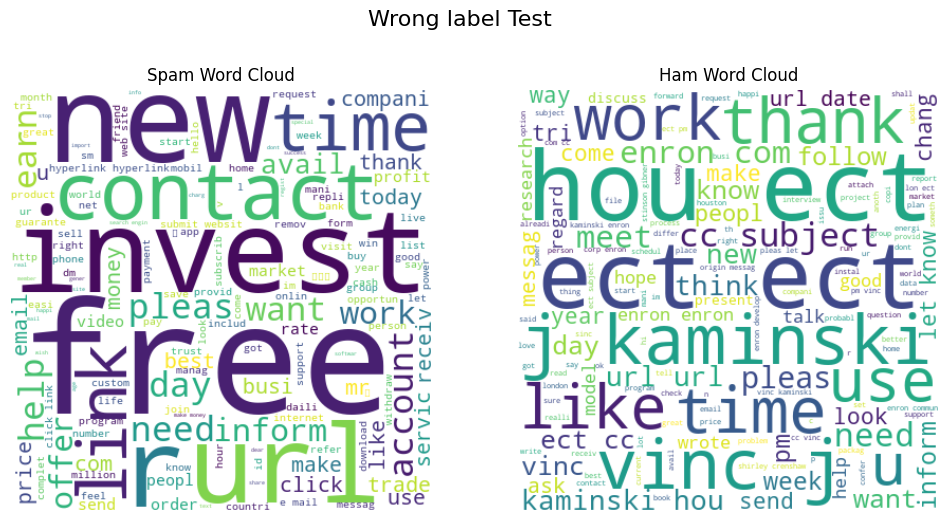

In [99]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

vis_df = DataVisualizer(df)
vis_test.visualize_wordclouds("Wrong label Test")

In [100]:
def predict(clf, text):
    text_preprocessed = preprocess_text(text)
    # Dự đoán nhãn cho văn bản đã được tiền xử lý
    y_pred = clf.predict([text_preprocessed])
    return y_pred

In [101]:
text = 'In morning, please charge my mobile when you get up '
predict(clf, text)

array([0], dtype=int64)